# Ticket Clustering

## Overview

The following notebook will explore the creation and utility of a model that attempts to cluster tickets by a set of defined features.
The model will analyze the information provided by the ticket and the user interactions with the ticket to illuminate ticket similarities within a specific repository or project that could give further insight on the code associated. We're trying to discover if similarities between ticket, specifically negative, can give further insight into the code and better help the user understand their code base. 

## Uses

To fully know the impact of the type of similarities discovered from the tickets, examination of the code will be conducted. But in a general sense, grouping and visualizing the way all tickets are interacting within the repository or codebase can provide important information to the user. The groupings can be further specified to the individual user and show how those interact with other tickets. This information can lead the user to dig deeper into effects or problems occuring from a certain cluster of tickets. 

# Imports

In [1]:
from collections import Counter
import re

from it_topic_naming import ITTopicNamer
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import networkx as nx
from networkxgmml import XGMMLReader
from sklearn.cluster import KMeans
from sklearn import metrics, pipeline, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from tqdm import tqdm
from wordcloud import WordCloud
from time import time
from sklearn.preprocessing import scale

# Data

The data is obtained from ingested github repositories containing issues and commits. The data is provided in a directional graph.   
**The data had to be adjusted by removing unescaped characters in 18 different locations, will most likely need to repeated if there is a new round of ingested data**

In [2]:
graph_filename = "../12_02_graph.xgmml"

with open(graph_filename, "rb") as graph_file:
     G = XGMMLReader(graph_file)

In [4]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 9566
Number of edges: 28250
Average in degree:   2.9532
Average out degree:   2.9532


# Exploring & Preprocessing Data

## Get issue data

Issue data is obtained from DiGraph and then turned into a dataframe with all its corresponding values. The dataframe contains 16 columns and 1213 rows. 

In [84]:
issue_df=pd.concat([pd.DataFrame([[u]+list(G.node[u].values())], columns=["issue id"]+list(G.node[u].keys())) for u in G.nodes() if "issue" in u ], 
                   ignore_index=True).set_index("issue id")

### Number of non-`NaN` values in each column

In [ ]:
len(issue_df)

In [ ]:
issue_df.notna().sum()

In [8]:
## Replace null or empty string with NaN

issue_df.replace(["null",""], np.NaN, inplace=True)
print(issue_df.notna().sum())

label            1216
name             1216
owner            1216
repo_id          1216
url              1216
additions           0
author_key          0
closed_date      1158
created_date     1216
deletions           0
description      1152
files_changed       0
id               1216
merger_key          0
number           1216
status           1216
title            1216
updated_date     1216
dtype: int64


In [9]:
## Remove columns with no values

issue_df.drop(['additions', 'author_key', 'deletions','files_changed', 'merger_key'], axis=1, inplace=True)
print(issue_df.notna().sum())

label           1216
name            1216
owner           1216
repo_id         1216
url             1216
closed_date     1158
created_date    1216
description     1152
id              1216
number          1216
status          1216
title           1216
updated_date    1216
dtype: int64


### Label Field

In [88]:
label_list = [(u,v) for u,v,d in G.edges(data=True) if ("label" in v) & ("issue" in u)]
label_df = pd.concat([pd.DataFrame([[u]+list(G.node[v].values())], columns=["issue id"]+list(G.node[v].keys())) for u,v in label_list], 
                 ignore_index=True).set_index("issue id")

In [91]:
issue_label_df= pd.merge(issue_df, label_df['name'], on='issue id', how='outer').rename(columns={"name_y":"label_name"})

In [92]:
issue_label_df

,label,name_x,owner,repo_id,url,additions,author_key,closed_date,created_date,deletions,description,files_changed,id,merger_key,number,status,title,updated_date,label_name
issue id,,,,,,,,,,,,,,,,,,,
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,null,null,2010-12-03T22:31:59+00:00,2010-11-19T00:13:24+00:00,null,"On Mac OS X (at least 10.6.4+), there's no nee...",null,427508,null,1,closed,Mac OS X support for compilation,2014-07-17T10:50:53+00:00,NaN
issues/6036d01e-bee1-5a3c-a423-37db00e22778,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,null,null,2012-09-25T21:11:53+00:00,2012-09-23T00:59:59+00:00,null,Updated the readme.md file to reflect the need...,null,7064741,null,108,closed,Updated readme.md to reflect requirements for ...,2012-09-25T21:11:53+00:00,NaN
issues/f8aefd85-8c03-519e-82dc-cca0388363b4,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,null,null,2012-11-04T03:27:49+00:00,2012-10-02T00:58:27+00:00,null,This should make the version requirement for w...,null,7280739,null,116,closed,updated readme for 64bit windows install,2014-06-18T13:41:07+00:00,NaN
issues/fce88d5c-2e92-560b-a9cb-1d9dfdc9249a,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,null,null,2013-04-28T22:06:45+00:00,2013-04-27T20:28:46+00:00,null,Support for domains so that async method will ...,null,13725651,null,162,closed,Add support for domains,2013-04-28T22:06:45+00:00,NaN
issues/d45a91b7-8c5d-5343-8cc7-4cbea8e818ff,Default-Label,ready,kelektiv,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,https://github.com/kelektiv/node-cron,null,null,2013-04-29T14:11:53+00:00,2013-04-28T22:07:06+00:00,null,Support for domains so that async method will ...,null,13741381,null,163,closed,support for domains,2014-07-29T01:20:13+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/6c7e0ca4-4802-547f-ab72-530cf765dabe,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,null,null,2019-08-25T09:48:34+00:00,2019-08-25T09:42:29+00:00,null,I don't know how to run it every x seconds.,null,484911300,null,436,closed,Sorry to ask: where is the documentation?,2019-08-25T09:48:34+00:00,NaN
issues/8cbe0d77-b705-5ef9-a870-4e5600828ed8,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,null,null,2019-09-07T13:59:36+00:00,2019-09-07T08:06:01+00:00,null,When installing on latest version of moleculer...,null,490607104,null,437,closed,npm WARN moleculer-cron@0.0.2 requires a peer ...,2019-09-07T13:59:36+00:00,NaN
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,Default-Label,ready,kelektiv,82668c86-65fa-4bec-a9ad-3e3143df8ccb,https://github.com/kelektiv/node-cron,null,null,null,2019-09-25T21:41:51+00:00,null,The API documentation hasn't changed much sinc...,null,498538247,null,441,open,Rework the API Documentation so that it's more...,2019-10-11T12:50:19+00:00,Hacktoberfest


### Converting date columns with timezones to `Datetime`

In [12]:
def convert_datetime (columns, df):
    for col in columns: 
       df[col] = df[col].astype('datetime64[ns]')
       df[col] = df[col].dt.tz_localize('America/New_York')

In [13]:
## Get total duration of ticket, if ticket is closed
convert_datetime (["closed_date", "created_date"], issue_label_df)
issue_label_df["issue_duration"]=issue_label_df.apply(lambda row: 
                                              np.nan if not row["closed_date"] else row["closed_date"]-row["created_date"], axis=1 )

## Get comment data

In [94]:
comments_list = [(u,v) for u,v,d in G.edges(data=True) if "issues" in u]
comment_df = pd.concat([pd.DataFrame([[u]+list(G.node[v].values())], 
                                     columns=["issue id"]+list(G.node[v].keys())) for u,v in comments_list ], 
                   ignore_index=True).set_index("issue id")
comment_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,additions,author_key,body,closed_date,comment_key,content,created_date,date,deletions,description,...,owner,path,published_date,repo_id,status,tag,title,updated_date,url,username
issue id,,,,,,,,,,,,,,,,,,,,,
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,null,null,NaN,2012-05-10T23:19:57+00:00,NaN,NaN,2012-04-01T12:38:09+00:00,NaN,null,"I tried to install mongoose-auth with npm, but...",...,kelektiv,NaN,NaN,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,closed,NaN,Install failing on OS X,2012-05-10T23:19:57+00:00,https://github.com/kelektiv/node-cron,NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,null,null,NaN,2012-04-18T14:08:16+00:00,NaN,NaN,2012-04-18T12:55:51+00:00,NaN,null,Stack trace and anything I thought relevant in...,...,kelektiv,NaN,NaN,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,closed,NaN,Install fails on Centos 5.3,2012-04-18T14:17:49+00:00,https://github.com/kelektiv/node-cron,NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,null,null,NaN,2012-05-10T23:18:46+00:00,NaN,NaN,2012-04-30T06:20:18+00:00,NaN,null,I'm trying to download bcrypt with npm but it ...,...,kelektiv,NaN,NaN,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,closed,NaN,bcrypt.js failed to download and build on Cent...,2019-03-08T06:09:59+00:00,https://github.com/kelektiv/node-cron,NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,null,null,NaN,2012-07-04T17:33:48+00:00,NaN,NaN,2012-06-20T00:08:21+00:00,NaN,null,Here's error log: npm http GET https://regist...,...,kelektiv,NaN,NaN,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,closed,NaN,npm package won't build,2012-07-06T03:47:10+00:00,https://github.com/kelektiv/node-cron,NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643,null,null,NaN,2015-04-17T19:39:56+00:00,NaN,NaN,2015-04-17T02:47:01+00:00,NaN,null,I'm struggling with this issue for last severa...,...,kelektiv,NaN,NaN,d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93,closed,NaN,Can't build / can't install bcrypt on Windows,2015-04-17T19:39:57+00:00,https://github.com/kelektiv/node-cron,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,1,null,That would be great. Thanks!,2019-11-22T02:19:17+00:00,NaN,NaN,2019-10-10T01:03:12+00:00,NaN,1,"Hello, Some cron patterns like `* * * * * * *...",...,kelektiv,lib/cron.d.ts,NaN,82668c86-65fa-4bec-a9ad-3e3143df8ccb,closed,NaN,Improve detection of incorrect cron pattern,2019-10-10T01:03:12+00:00,https://github.com/kelektiv/node-cron,NaN
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,1,null,One quick question: reworking the API document...,2019-11-22T02:19:17+00:00,NaN,NaN,2019-10-11T08:46:12+00:00,NaN,1,"Hello, Some cron patterns like `* * * * * * *...",...,kelektiv,lib/cron.d.ts,NaN,82668c86-65fa-4bec-a9ad-3e3143df8ccb,closed,NaN,Improve detection of incorrect cron pattern,2019-10-11T08:46:12+00:00,https://github.com/kelektiv/node-cron,NaN
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,1,null,@balajipachai yes. Right now it's too condense...,2019-11-22T02:19:17+00:00,NaN,NaN,2019-10-11T12:50:19+00:00,NaN,1,"Hello, Some cron patterns like `* * * * * * *...",...,kelektiv,lib/cron.d.ts,NaN,82668c86-65fa-4bec-a9ad-3e3143df8ccb,closed,NaN,Improve detection of incorrect cron pattern,2019-10-11T12:50:19+00:00,https://github.com/kelektiv/node-cron,NaN


In [95]:
with pd.option_context('display.max_rows', None):
    display(comment_df["body"])

issue id
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-5e49-9f32-dd84a403f643                                                  NaN
issues/6aedf8a0-9534-

In [15]:
comment_df["Comment Length"]= comment_df["body"].apply(lambda comment: len(str(comment).split()))

In [17]:
comment_df["body"].fillna("", inplace=True)
comment_bodies = pd.DataFrame(comment_df.groupby("issue id").agg({"body": ", ".join}))
comment_bodies["body"] =[str(label) for label in comment_bodies["body"]]
comment_bodies.isnull().sum()

body    0
dtype: int64

In [18]:
comment_stats=comment_bodies
comment_stats["# of Comments"]=comment_df.groupby("issue id").size()
comment_stats["Average Length of Comments"]=comment_df.groupby("issue id")["Comment Length"].mean()

## Adjacency Matrix

In [51]:
print(test_test_test)

1


In [72]:
H = G.subgraph([u for u in G.nodes() if "issues" in u])
issues_matrix = nx.to_pandas_adjacency(H)
adj_matrix = issues_matrix[[col for col in issues_matrix.columns
                            if (col.split("/")[0] in ["pull_requests", "labels", "issues", "commits", "comments"])]].merge( 
    issue_df["repo_id"], left_index=True, right_index=True)

for index in adj_matrix.index:
    adj_matrix.at[index, index] = 1

grouped_matrix = [pd.DataFrame(adj_matrix.groupby("repo_id").get_group(x)) for x in adj_matrix.groupby("repo_id").groups]

grouped_matrix[0]

,issues/b6f4a4cd-c357-506c-b4b6-1c5abb1844e0,issues/b7bbaab1-2800-5aa4-b267-3ce80155f91d,issues/70d16507-4a85-58ff-90c7-b31bb9b533c3,issues/c98fb3ac-b211-55e2-bffa-d29b0ffe9d84,issues/e8dbe2bd-8943-56a8-93d4-72c1335ffbba,issues/78e154d4-6d67-57c2-ae45-a5d5bdd7be37,issues/4ea7a53e-6954-5e7c-b5d3-8fa68720f1df,issues/376103ad-2a6e-55f0-ab1e-7be9f5415f22,issues/7b92783b-90d7-50bc-8346-0d0af7f6de3c,issues/a8f3fa0d-0799-57dc-98b5-f52ec20f46cf,...,issues/13794714-da43-5549-bd45-6ef5feb6a71a,issues/810a3e3f-5a03-571d-be41-e4dd8cecbccc,issues/4fd98226-bd4c-5bd8-8c38-1b1da874c3cf,issues/6ff744c0-4d1d-56c4-b32a-d1e8dadde0f7,issues/8885d634-8e75-5ace-9217-da42e139bbd8,issues/f3aa9b9b-10c2-5b5c-9953-4b7df64d6dc3,issues/e6674960-1b2b-55c1-8a21-a35cdc8635ce,issues/42d7bd45-87ed-5f61-be64-dac32be8ece7,issues/dc7c55a1-bc8f-5643-93f0-844b579628cd,repo_id
issues/b6f4a4cd-c357-506c-b4b6-1c5abb1844e0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/70d16507-4a85-58ff-90c7-b31bb9b533c3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/c98fb3ac-b211-55e2-bffa-d29b0ffe9d84,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/e8dbe2bd-8943-56a8-93d4-72c1335ffbba,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/376103ad-2a6e-55f0-ab1e-7be9f5415f22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/93df2f2e-6c5c-525a-8b95-dbc199dde605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/13794714-da43-5549-bd45-6ef5feb6a71a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/4fd98226-bd4c-5bd8-8c38-1b1da874c3cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb
issues/42d7bd45-87ed-5f61-be64-dac32be8ece7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,82668c86-65fa-4bec-a9ad-3e3143df8ccb


## Final Dataset

In [87]:
final_df=pd.merge(issue_label_df, comment_stats, on="issue id", how="left")

NameError: name 'issue_label_df' is not defined

In [86]:
final_df.size()

NameError: name 'final_df' is not defined

In [75]:
final_df.fillna("", inplace=True)

# Vectorization

## Features

* Issue in general 
    * [x] Total Duration
    * [x] Status
    * [x] Create Date
    * [x] Updated Date
    * [ ] Whether the issue was cross referenced
    * [ ] Event features?
* Issue Title
    * [ ] Length of title?
    * [x] TFIDF title
* Issue Description 
    * [ ] Length of description
    * [ ] Formatting
    * [ ] Contains links, urls, images?
    * [x] TFIDF
* Comments per Issue
    * [ ] Days between first comment and issue creation?
    * [ ] Days between last comment and issue creation?
    * [ ] Number of comments
    * [ ] Average length of comments
    * [ ] Number of unique users
    * [ ] TFIDF
    

### Feature functions

In [76]:
def return_var(series):
    return np.array([str(item) for item in series]).reshape(-1, 1)

def count(series):
    return np.array([len(item) for item in series]).reshape(-1, 1)

def body_length(series):
    return np.array([len(str(item[0]).split()) for item in series]).reshape(-1, 1)

def num_headers(series):
    return np.array([len(re.findall("##", str(item))) for item in series]).reshape(-1, 1)

def num_urls(series):
    return np.array([len(re.findall("https://", str(item))) for item in series]).reshape(-1, 1)

def num_code_blocks(series):
    return np.array([len(re.findall("{code}", str(item))) for item in series]).reshape(-1, 1)


In [77]:
mapper = DataFrameMapper([
    (['label_name'], preprocessing.LabelEncoder(), {'alias': "Label"}),
    (['# of Comments'], [preprocessing.FunctionTransformer(count, validate=False),
                   preprocessing.MinMaxScaler()], {'alias': "Num Comments"}),
    (['status'], preprocessing.OneHotEncoder()),
    (['description'], [preprocessing.FunctionTransformer(body_length, validate=False),
                       preprocessing.MinMaxScaler()], {'alias': "Description Length"}),
    ('description', [preprocessing.FunctionTransformer(num_headers, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Headers"}),
    ('description', [preprocessing.FunctionTransformer(num_urls, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num URLs"}),
    ('description', [preprocessing.FunctionTransformer(num_code_blocks, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Code Blocks"}),
    ('description', [CountVectorizer(min_df=2, max_df=0.95), 
                     TfidfTransformer()], {"alias": "Tfidf_description"}),
    ('title', [CountVectorizer(max_df=0.95), 
               TfidfTransformer()], {"alias": "Tfidf_title"}),
    (['title'], [preprocessing.FunctionTransformer(body_length, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Title Length"}),
    ('body', [CountVectorizer(max_df=0.95), 
               TfidfTransformer()], {"alias": "Tfidf_comment_body"}),
    ('body', [preprocessing.FunctionTransformer(num_headers, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Headers: Comment"}),
    ('body', [preprocessing.FunctionTransformer(num_urls, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num URLs: Comment"}),
    ('body', [preprocessing.FunctionTransformer(num_code_blocks, validate=False),
                     preprocessing.MinMaxScaler()], {'alias': "Num Code Blocks: Comment"}),

], df_out=True)

## Split dataframe by repository & Vectorize

In [83]:
grouped_dfs = [pd.DataFrame(final_df.groupby('repo_id').get_group(x)) for x in final_df.groupby('repo_id').groups]

vectors_dfs = [mapper.fit_transform(df) for df in grouped_dfs]
vectors_dfs[0]
#vectors_dfs = [[mapper.fit_transform(df).merge(matrix_df, left_index = True, right_index=True ) for matrix_df in grouped_matrix if ] for df in grouped_dfs] 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Label,Num Comments,status_x0_closed,status_x0_open,Description Length,Num Headers,Num URLs,Num Code Blocks,Tfidf_description_00,Tfidf_description_000,...,Tfidf_comment_body_zeros,Tfidf_comment_body_zhangxiang958,Tfidf_comment_body_zip,Tfidf_comment_body_zolmeister,Tfidf_comment_body_zone,Tfidf_comment_body_zones,Tfidf_comment_body_预祝你圣诞快乐,Num Headers: Comment,Num URLs: Comment,Num Code Blocks: Comment
issue id,,,,,,,,,,,,,,,,,,,,,
issues/87b2f454-d7ef-5a61-bf2f-002c62a05111,0,0.0,1.0,0.0,0.013245,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
issues/d76660ed-d1df-548b-a40f-4aec1ff0b11c,0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.166667,0.0
issues/f092a337-12d7-5844-b4ce-1e0157f56f86,0,0.0,1.0,0.0,0.003784,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
issues/206aceef-033b-5aaa-a764-b6f2d0aceb48,0,0.0,1.0,0.0,0.119205,0.0,0.333333,0.0,0.364202,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
issues/f06118f2-8b20-57de-b471-b8681d83c1f9,0,0.0,1.0,0.0,0.026490,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
issues/6c7e0ca4-4802-547f-ab72-530cf765dabe,0,0.0,1.0,0.0,0.009461,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
issues/8cbe0d77-b705-5ef9-a870-4e5600828ed8,0,0.0,1.0,0.0,0.028382,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
issues/56122d45-3b22-503e-a10a-ce13afd4bb9d,1,0.0,0.0,1.0,0.024598,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0


## Kmeans

In [32]:
def run_methods (n, vectors_dfs):
    for i,vectors_df in enumerate(vectors_dfs):
        kmeans = KMeans(init='k-means++', n_clusters=n[i], random_state=0, n_init=10)
        pred = kmeans.fit_transform(vectors_df)
        print("Repo: " + str(df["repo_id"].iloc[1]))
        print(str(Counter(kmeans.predict(vectors_df))))
        get_cluster_graph(kmeans, vectors_df)

def get_cluster_graph(kmeans,vectors_df):
    # Visualize the results on PCA-reduced data

    reduced_data = PCA(n_components=2).fit_transform(vectors_df)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('K-means clustering (PCA-reduced data)\n'
          'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
def get_elbow_graph(df, pred):
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k)
        km.fit(pred)
        sse.append(km.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.title(str(df["repo_id"].iloc[1]))
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


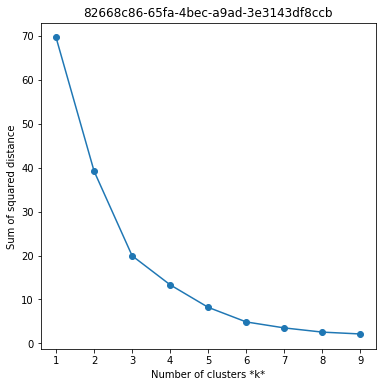

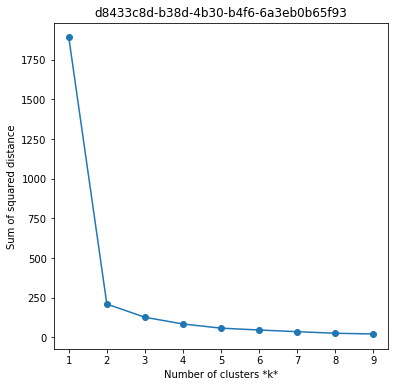

In [33]:
for vectors_df in vectors_dfs:
    kmeans = KMeans(init='k-means++', n_clusters=5, random_state=0, n_init=10)
    pred = kmeans.fit_transform(vectors_df)
    get_elbow_graph(df, pred)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Repo: 82668c86-65fa-4bec-a9ad-3e3143df8ccb
Counter({4: 191, 2: 142, 0: 91, 3: 15, 1: 9})


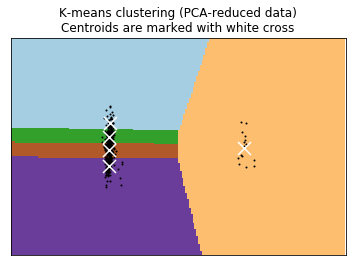

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Repo: d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93
Counter({3: 300, 4: 230, 2: 181, 0: 38, 1: 21})


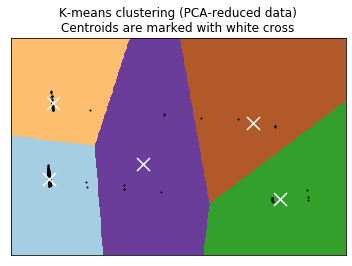

In [34]:
run_methods([5,5], grouped_dfs)

In [108]:
kmeans = KMeans(init='k-means++', n_clusters=5, random_state=0, n_init=10).fit(vectors_dfs[0])
preds = kmeans.predict(vectors_dfs[0])

## Add topic names to clusters

In [111]:
grouped_dfs[0].loc[vectors_dfs[0].index[0]]["description"]

'Hi, I just added exports.CronTime = CronTime so that I can validate cron patterns. '

In [112]:
from collections import defaultdict

tid_to_descriptions = defaultdict(list)

for idx, pred in enumerate(preds):
    tid_to_descriptions[pred].append(grouped_dfs[0].loc[vectors_dfs[0].index[idx]]["description"])

In [113]:
{tid: len(descriptions) for tid, descriptions in tid_to_descriptions.items()}

{2: 142, 4: 191, 0: 91, 3: 15, 1: 9}

In [114]:
tid_to_descriptions

defaultdict(list,
            {2: ['Hi, I just added exports.CronTime = CronTime so that I can validate cron patterns. ',
              'This fix issue #112. ',
              'For compatibility with Node 0.11.x and Windows. All tests are passing and I made the moment-timezone dependency obligatory inside the module. Feel free to change whatever you want ',
              "Reproduce issue with this:  var CronTime = require('cron').CronTime; var validSource = '0 \\* \\* \\* \\* *'; var validTimezone = 'UTC'; var invalidFromDate = new Date('2014-12-01-bogus'); var date = new CronTime(validSource, validTimezone)._getNextDateFrom(invalidFromDate); console.log(date.getTime()); ",
              'fix tabs and spaces mixing ',
              'Before this commit, `lib/cron.js` was a hodge podge of tab indentation and two-space indentation.  This commit changes all tab indents to two spaces.  It might be noted that for the first three lines (2-4), I left the indentation at 4 spaces (well, from 2 ta

In [115]:
topic_namer = ITTopicNamer(tid_to_descriptions, num_top_keyphrases=3, topic_name_min_df=1)
topic_namer.get_all_topic_names()

{2: 'Trying to Run My Cron Job, Single Cron Task at a Specific, CREATE a Job Using the Command',
 4: 'Start Cron Test Check Hour, Largest Instances Array Compiled Code, Cron Test Check Hour 2015-04-16t20:59:01.011z Start',
 0: 'New Time Set (i.e.) Cron Job, Using Cron Job to Run, Javascript Var Job1 = New',
 3: 'Called at Midnight New York Time, Midnight New York Time, Called at Midnight New York',
 1: 'Cron Project Following Logs, Went Wrong. Cron Reached Maximum, Received From Our Cron Project Following'}

## Supervised Methods/Metrics

references: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html  
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

In [98]:
def get_results(repo_id, n_samples, n_features, n_labels, data, labels):
    print("Repo: " + str(repo_id))
    print("n_labels: %d, \t n_samples %d, \t n_features %d"
      % (n_labels, n_samples, n_features))
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

    bench_k_means(labels, KMeans(init='k-means++', n_clusters=n_labels, n_init=10),
              name="k-means++", data=data)

    bench_k_means(labels, KMeans(init='random', n_clusters=n_labels, n_init=10),
              name="random", data=data)

    pca = PCA(n_components=n_labels).fit(data)
    bench_k_means(labels, KMeans(init=pca.components_, n_clusters=n_labels, n_init=1),
              name="PCA-based", data=data)
    print(82 * '_')
    
def bench_k_means(labels, estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=300)))

In [108]:
np.random.seed(42)

for df in grouped_dfs:
    data = mapper.fit_transform(df)
    n_samples, n_features = data.shape
    n_labels = len(np.unique(data["Label"]))
    labels = data["Label"]
    repo_id = df["repo_id"][1]
    get_results(repo_id, n_samples, n_features, n_labels, data, labels)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Repo: 82668c86-65fa-4bec-a9ad-3e3143df8ccb
n_labels: 2, 	 n_samples 448, 	 n_features 6651
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.27s	1210	0.080	0.044	0.057	0.157	0.049	0.145
random   	1.11s	1226	0.177	0.021	0.038	0.015	0.035	0.011
PCA-based	0.11s	1210	0.080	0.044	0.057	0.157	0.049	0.154
__________________________________________________________________________________


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Repo: d8433c8d-b38d-4b30-b4f6-6a3eb0b65f93
n_labels: 8, 	 n_samples 770, 	 n_features 18855
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	10.41s	1977	0.773	0.147	0.246	0.112	0.228	0.020
random   	11.73s	1972	0.773	0.111	0.194	0.049	0.175	0.043
PCA-based	1.53s	1974	0.633	0.088	0.154	0.045	0.133	0.031
__________________________________________________________________________________


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


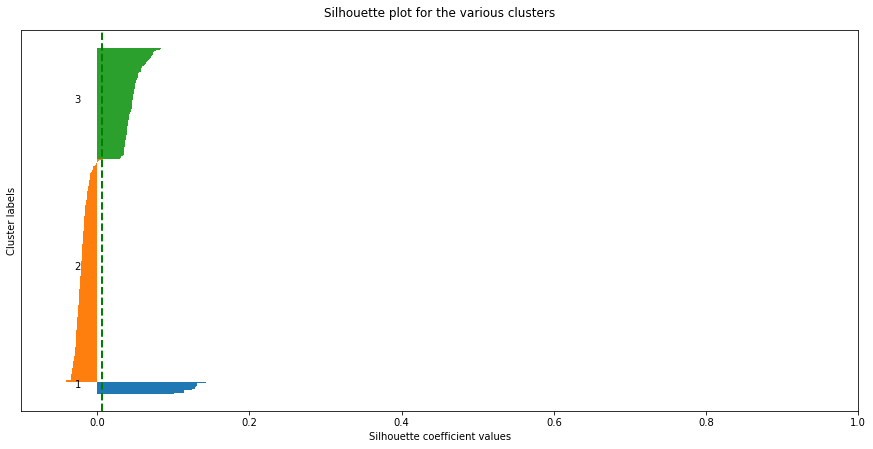

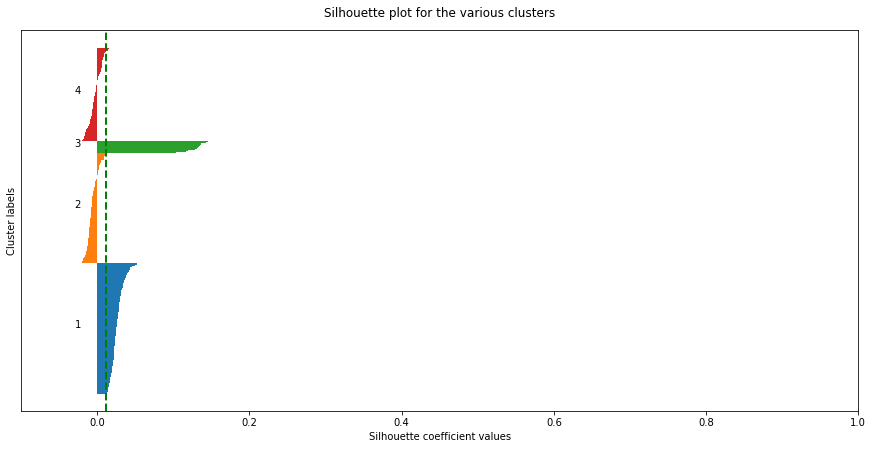

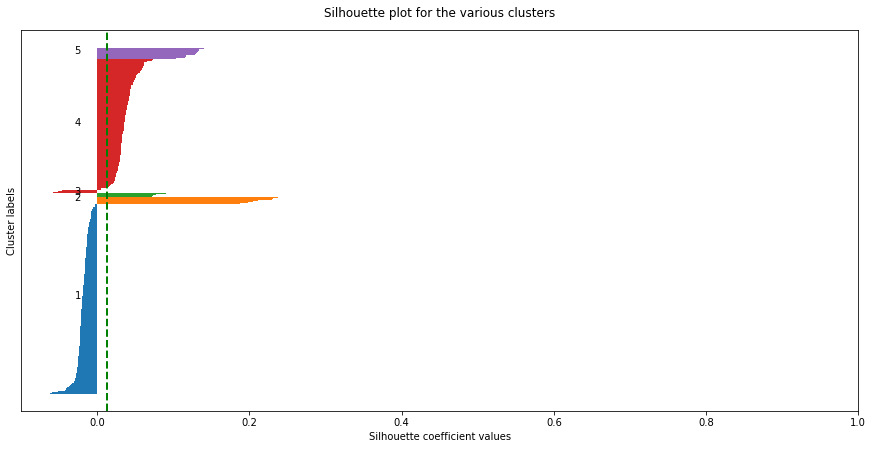

In [66]:
vectors_df = mapper.fit_transform(grouped_dfs[0])
for i, k in enumerate([3, 4, 5]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(15, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(vectors_df)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = metrics.silhouette_samples(vectors_df, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

# Possible methods for clustering tickets

Supervised versus Unsupervised: 
    What is the benefit of choosing supervised for this task?
    
**Unsupervised Methods:** 
KMEANs

**Supervised Methods:**

SVMs (Support Vector Machines): 
    Pros: Good for high dimensional data sets and okay when there are more dimensions than samples
    Something to keep in mind: Need to adjust for overfitting with kernels
    
Nearest Neighbor Component Analysis: 
    Pros: Doesn't introduce additional parameters that require fine-tuning by the user. 
            Doesn't make assumptions about the class distributions.
            Can naturally produce highly irregular decision boundaries. 
            Can perform supervised dimensionality reduction. 



By assignee and by project (for sure) grouby by project pick the one with the biggest time span. focus on one. then replicate it on other. 


# Results

## Discussion

For this sprint and experiment, we decided to move forward with unsupervised models. We decided to use unsupervised models as a starting point to further investigate how the issues are clustered without choosing a label. The goal was to choose an appropriate label for supervised models based on features found in the unsupervised models. 

Based on the unsupervised models, including ... , we determined that ....

## Next Steps

Due to the time constraints of the holidays, during this sprint the clustering model only included features that could be obtained from the current ingest of Github attributes. For the next sprint, barring any complications, we hope to include events attributes that would include whether an issue was cross references with another issue, different time events, assignee information and corresponding commit information. 